# Análisis de Sentimientos en Reviews

En este análisis, se recopilaron reseñas de hoteles  con el objetivo de evaluar el sentimiento expresado por los usuarios. Primero, se realiza una limpieza exhaustiva de los textos para eliminar palabras o expresiones que puedan sesgar los resultados. Posteriormente, se utiliza el servicio de Azure para analizar el sentimiento de cada reseña, clasificándolas en categorías como positivo, negativo, mixto o neutral. Este proceso permite obtener una visión más precisa y objetiva de la percepción de los clientes sobre los hoteles evaluados.

Cargar el Dataset de Reviews en español.

In [ ]:
!pip install pandas 

In [22]:
import pandas as pd

df = pd.read_csv('../data/raw/reviews_hotel.csv')
df.head()

,reviews.date,reviews.title,reviews.text,reviews.rating
0,2013-09-22T00:00:00Z,Good location away from the crouds,Pleasant 10 min walk along the sea front to th...,4.0
1,2015-04-03T00:00:00Z,Great hotel with Jacuzzi bath!,Really lovely hotel. Stayed on the very top fl...,5.0
2,2014-05-13T00:00:00Z,Lugnt l��ge,Ett mycket bra hotell. Det som drog ner betyge...,5.0
3,2013-10-27T00:00:00Z,Good location on the Lido.,We stayed here for four nights in October. The...,5.0
4,2015-03-05T00:00:00Z,������ ���������������,We stayed here for four nights in October. The...,5.0


In [23]:
import pandas as pd

df_es = pd.read_csv('../data/raw/reviews_hotel_es.csv')
df_es.head()

,hotel_name,location,wrote,rating,title,review_text
0,Secrets Cap Cana Resort & Spa,"Villaviciosa, Spain",December 2021,5,Vacaciones en El paraíso,El hotel impecable todo muy limpio las habitac...
1,Secrets Cap Cana Resort & Spa,"Villaviciosa, Spain",December 2021,5,HOTEL de la EXCELENCIA,"EXCELENTE, magnífico, excepcional, maravilloso..."
2,Secrets Cap Cana Resort & Spa,"Villaviciosa, Spain",December 2021,5,Sentirse como en CASA!!!!!,Tras conocer bastantes hoteles en distintos lu...
3,Secrets Cap Cana Resort & Spa,"Villaviciosa, Spain",December 2021,5,Muy buen nivel,Muy buen hotel. Cumple con todos los requisito...
4,Secrets Cap Cana Resort & Spa,"Villaviciosa, Spain",December 2021,5,10,Excelente todo ....sobre todo el personal. Es ...


## Limpieza da datos de Reseñas
Para nuestro ejemplo necesitamos unicamente las reseñas que en nuestro dataset es `reviews.text` y `review_text`

In [24]:
# Elinas columnas innecesarias
df = df.drop(columns=['reviews.date', 'reviews.title', 'reviews.rating'])
df_es = df_es.drop(columns=['hotel_name', 'location', 'wrote', 'rating', 'title'])

# Cambiamos el nombre de las columnas
df = df.rename(columns={
    'reviews.text': 'review',
})

df_es = df_es.rename(columns={
    'review_text': 'review',
})

# Concatenamos los dataframes
df = pd.concat([df, df_es], ignore_index=True)

# Limpiamos los espacios en blanco y los caracteres especiales
df['review'] = df['review'].str.strip()
df['review'] = df['review'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
df['review'] = df['review'].str.replace(r'\s+', ' ', regex=True)

# Convertimos a minúsculas
df['review'] = df['review'].str.lower()

# Eliminamos filas vacías
df = df[df['review'] != '']

# Eliminamos duplicados
df = df.drop_duplicates(subset=['review'])

# Eliminamos filas con valores nulos
df = df.dropna(subset=['review'])

# Guardamos el dataframe limpio
df.to_csv('../data/processed/reviews_hotel_clean.csv', index=False)

# Mostramos las primeras filas del dataframe limpio
df.count()

review    66341
dtype: int64

## Análisis de Sentimientos
Ahora con el dataset limpio veremos que sentimiento tiene cada una.

In [ ]:
!pip install azure-ai-textanalytics==5.3.0

In [ ]:
# Analizar los sentimientos con Azure
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

KEY = ""
ENDPOINT = ""


# Autenticación del cliente
credential = AzureKeyCredential(KEY)
client = TextAnalyticsClient(endpoint=ENDPOINT, credential=credential)

text = "review"

# Convertir a lista
documentos = df[text].dropna().astype(str).tolist()

# Azure permite máx. 10 documentos por request, así que lo haremos por lotes
def analizar_sentimientos_por_lotes(textos, lote=10):
    resultados = []

    for i in range(0, len(textos), lote):
        batch = textos[i:i+lote]
        response = client.analyze_sentiment(documents=batch)

        for idx, doc in enumerate(response):
            if not doc.is_error:
                resultados.append({
                    "text": batch[idx],
                    "sentiment": doc.sentiment,
                })
            else:
                resultados.append({
                    "text": batch[idx],
                    "sentiment": "error",
                })
    return resultados

# Ejecutar análisis
resultados = analizar_sentimientos_por_lotes(documentos)

# Crear DataFrame con los resultados
df_resultados = pd.DataFrame(resultados)

# Mostrar los primeros resultados
print(df_resultados.head())

# Guardamos los resultados
df_resultados.to_csv('../data/processed/reviews_hotel_sentiment.csv', index=False)

                                                text sentiment
0  pleasant 10 min walk along the sea front to th...  positive
1  really lovely hotel stayed on the very top flo...  positive
2  ett mycket bra hotell det som drog ner betyget...  positive
3  we stayed here for four nights in october the ...  positive
4  we loved staying on the island of lido you nee...  positive


In [ ]:
!pip install matplotlib seaborn

C:\Users\Alumno_AI\AppData\Local\Temp\ipykernel_13588\4090986831.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


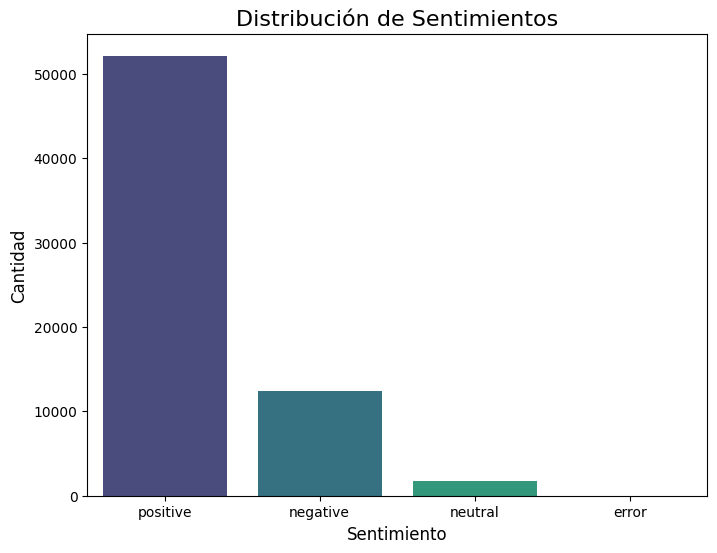

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# grafica para ver el porcentaje de positive, negative, mixed, neutral
# Contar la cantidad de cada sentimiento
sentiment_counts = df_resultados['sentiment'].value_counts()

# Configurar la gráfica
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

# Títulos y etiquetas
plt.title('Distribución de Sentimientos', fontsize=16)
plt.xlabel('Sentimiento', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)

# Mostrar la gráfica
plt.show()